In [9]:
import re

import keras.backend as keras_backend
from keras.layers import Conv1D, Lambda, Add
import numpy as np
import matplotlib.pylab as plt

from traits.api import Enum, HasStrictTraits, Int, Instance, List, Tuple

from blusky.transforms.apply_father_wavelet_1d import ApplyFatherWavlet1D
from blusky.transforms.cascade_tree import CascadeTree
from blusky.transforms.cascade_1d import Cascade1D

from blusky.transforms.default_decimation import (NoDecimation, 
                                                  DefaultDecimation)
from blusky.transforms.i_decimation_method import IDecimationMethod
from blusky.wavelets.i_wavelet_1d import IWavelet1D
from blusky.utils.pad_1d import pad_to_log2, Pad1D

In [10]:
from os import path
import blusky.datasets as datasets

ts_path = path.join(
    path.dirname(datasets.__file__), "timeseries.csv"
)
my_data = np.genfromtxt(ts_path, delimiter=',', skip_header=1)
ts = my_data[:,1]

In [11]:
len(ts)

252

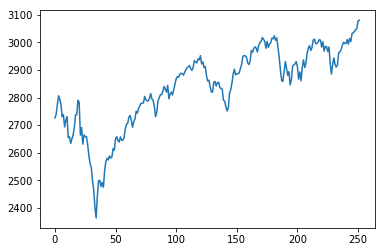

In [12]:
plt.figure()
plt.plot(ts)
plt.show()

In [26]:
from blusky.wavelets.wavelet_factories_1d import (vanilla_gabor_1d, 
                                                  vanilla_morlet_1d)
from keras.layers import Input
from keras import Model

N = 128
order = 1
sample_rate = 0.001

J = int(np.log2(N) - 2)

wavelets = [vanilla_morlet_1d(sample_rate, j=i) 
                    for i in range(0,J)]
father_wavelet = vanilla_gabor_1d(sample_rate, j=J-1)

deci = DefaultDecimation(oversampling=1)
inp = Input(shape=(N,1))

# pad
pad_1d = Pad1D(wavelets, decimation=deci)
padded = pad_1d.pad(inp)

#
cascade_tree = CascadeTree(padded, order=order)
cascade = Cascade1D(decimation=deci)
convs = cascade.transform(cascade_tree, wavelets=wavelets)

# Create layers to remove padding
cascade_tree = CascadeTree(padded, order=order)
cascade_tree.generate(wavelets, pad_1d._unpad_same)
unpad = cascade_tree.get_convolutions()

# Remove the padding
unpadded_convs = [i[1](i[0]) for i in zip(convs, unpad)]

appl = ApplyFatherWavlet1D(wavelet=father_wavelet, 
                           J=J-1, img_size=(N,), sample_rate=sample_rate)

sca_transf = appl.convolve(unpadded_convs)

model = Model(inputs=inp, outputs=sca_transf)
#model.summary()

data = np.zeros((1,N,1))
data[0,:,0] = ts[124:]
result = model.predict(data)
print(np.squeeze(np.array(result)))

[6.3973746 4.479191  2.7176552 1.7101843 1.6996995]


In [27]:
len(ts[124:])

128